In [153]:
import pandas as pd

In [211]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [163]:
X=train
y=X.pop("SalePrice")

In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [156]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

In [231]:
from sklearn.ensemble import RandomForestRegressor

X=train.copy().drop(columns=['TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']) 
X=X.loc[X["LotArea"]<100000, :]   #OUTLIERS
y=X.pop("SalePrice")

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2, random_state=42)

num_cols = X_train_all.select_dtypes(include="number").columns
cat_cols = X_train_all.select_dtypes(exclude="number").columns

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  MinMaxScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='N_A')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)])

rf_model = RandomForestRegressor(n_estimators=70, random_state=42)

pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_model)])

pipeline_rf.fit(X_train_all, y_train_all)

y_train_pred_rf = pipeline_rf.predict(X_train_all)
y_test_pred_rf = pipeline_rf.predict(X_test_all)

train_rmse_rf = mean_squared_error(y_train_all, y_train_pred_rf, squared=False)
test_rmse_rf = mean_squared_error(y_test_all, y_test_pred_rf, squared=False)
train_r2_rf = r2_score(y_train_all, y_train_pred_rf)
test_r2_rf = r2_score(y_test_all, y_test_pred_rf)

print(f"Train RMSE (Random Forest): {train_rmse_rf:.2f}")
print(f"Test RMSE (Random Forest): {test_rmse_rf:.2f}")
print(f"Train R^2 score (Random Forest): {train_r2_rf:.2f}")
print(f"Test R^2 score (Random Forest): {test_r2_rf:.2f}")

#n_estimators=100, random_state=42  28974.05   25092 70n-estim

Train RMSE (Random Forest): 11794.95
Test RMSE (Random Forest): 25092.51
Train R^2 score (Random Forest): 0.98
Test R^2 score (Random Forest): 0.90


In [51]:
test["SalePrice"]=pipeline_rf.predict(test)
new=test[["Id", "SalePrice"]]
new.to_csv("first_try.csv", index=False)

In [232]:
import numpy as np

y_train_pred_all_log = np.log(y_train_pred_rf)
y_test_pred_all_log = np.log(y_test_pred_rf)
y_train_all_log = np.log(y_train)
y_test_all_log = np.log(y_test)

from sklearn.metrics import mean_squared_error

train_rmsle_all = np.sqrt(mean_squared_error(y_train_all_log, y_train_pred_all_log))
test_rmsle_all = np.sqrt(mean_squared_error(y_test_all_log, y_test_pred_all_log))

print(f"Train RMSLE: {train_rmsle_all:.5f}")
print(f"Test RMSLE: {test_rmsle_all:.5f}")

Train RMSLE: 0.06176
Test RMSLE: 0.14540


In [233]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(p=1, n_neighbors=7, weights='distance')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', knn_model)])

pipeline.fit(X_train_all, y_train_all)

y_train_pred_all = pipeline.predict(X_train_all)
y_test_pred_all = pipeline.predict(X_test_all)

train_rmse_all = mean_squared_error(y_train_all, y_train_pred_all, squared=False)
test_rmse_all = mean_squared_error(y_test_all, y_test_pred_all, squared=False)
train_r2_all = r2_score(y_train_all, y_train_pred_all)
test_r2_all = r2_score(y_test_all, y_test_pred_all)

print(f"Train RMSE: {train_rmse_all:.2f}")
print(f"Test RMSE: {test_rmse_all:.2f}")
print(f"Train R^2 score: {train_r2_all:.2f}")
print(f"Test R^2 score: {test_r2_all:.2f}")

Train RMSE: 0.00
Test RMSE: 33407.04
Train R^2 score: 1.00
Test R^2 score: 0.82


In [239]:
from sklearn.model_selection import GridSearchCV

knn_model = KNeighborsRegressor(weights='distance')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', knn_model)])

param_grid = {
    'model__n_neighbors':[3, 5, 7, 9] ,   # [7, 11, 12, 13]
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2]
}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train_all, y_train_all)

y_train_pred_all = grid_search.predict(X_train_all)
y_test_pred_all = grid_search.predict(X_test_all)

train_rmse_all = mean_squared_error(y_train_all, y_train_pred_all, squared=False)
test_rmse_all = mean_squared_error(y_test_all, y_test_pred_all, squared=False)
train_r2_all = r2_score(y_train_all, y_train_pred_all)
test_r2_all = r2_score(y_test_all, y_test_pred_all)

print(f"Train RMSE: {train_rmse_all:.2f}")
print(f"Test RMSE: {test_rmse_all:.2f}")
print(f"Train R^2 score: {train_r2_all:.2f}")
print(f"Test R^2 score: {test_r2_all:.2f}")
print("Best parameters:", grid_search.best_params_)

Train RMSE: 0.00
Test RMSE: 33407.04
Train R^2 score: 1.00
Test R^2 score: 0.82
Best parameters: {'model__n_neighbors': 7, 'model__p': 1, 'model__weights': 'distance'} 0.7181809440303135


In [218]:
X=train.drop(columns=["Id",'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea'])  #'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']
X=X.loc[X["LotArea"]<100000, :]
y=X.pop("SalePrice")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_cols = X_train.select_dtypes(include="number").columns
cat_cols = X_train.select_dtypes(exclude="number").columns

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  MinMaxScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='N_A')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)])

gbt_model = GradientBoostingRegressor(loss='squared_error', 
                                      learning_rate=0.075, 
                                      max_depth=3, 
                                      n_estimators=1500, 
                                      random_state=42)

pipeline_gbt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', gbt_model)])

pipeline_gbt.fit(X_train, y_train)

y_train_pred = pipeline_gbt.predict(X_train)
y_test_pred = pipeline_gbt.predict(X_test)

train_rmse_gbt = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse_gbt = mean_squared_error(y_test, y_test_pred, squared=False)
train_r2_gbt = r2_score(y_train, y_train_pred)
test_r2_gbt = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse_gbt:.2f}")
print(f"Test RMSE: {test_rmse_gbt:.2f}")
print(f"Train R^2 score: {train_r2_gbt:.5f}")
print(f"Test R^2 score: {test_r2_gbt:.5f}")    #25913.64   with feature_Selection   (#1500-25913.64)
# 19825.33, 0.91403 with LA < 70 000
# 21984.52 , 0.92375 with LA < 100 000
# 21115.91, 0.91914 with LA < 150 000

# Train RMSE: 2386.47
# Test RMSE: 22083.38
# Train R^2 score: 0.99909
# Test R^2 score: 0.92306

Train RMSE: 2535.53
Test RMSE: 22234.54
Train R^2 score: 0.99897
Test R^2 score: 0.92201


In [217]:
test["SalePrice"]=pipeline_gbt.predict(test)
new=test[["Id", "SalePrice"]]
new.to_csv("third_try.csv", index=False)

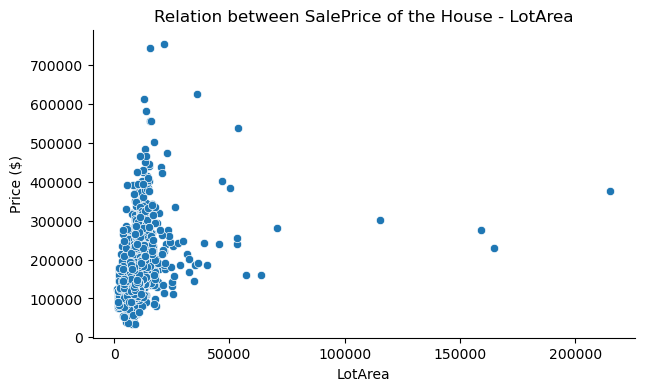

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 4))
sns.scatterplot(data=train, x='LotArea', y='SalePrice')   #GrLivArea
plt.title('Relation between SalePrice of the House - LotArea')
plt.ylabel('Price ($)')
sns.despine()

In [189]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive